In [31]:
import math
import random
from display_graph import draw_dot

In [32]:
class Value:
    def __init__(self, scalar, _children=(), _op=""):
        self.scalar = scalar
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        
        self._backward = lambda: None

    # nicer output
    def __repr__(self):
        return f"Value(scalar={self.scalar})"

    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(scalar=other)
        out = Value(self.scalar + other.scalar, (self, other), "+")
        print(other.grad)

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(scalar=other)
        out = Value(self.scalar * other.scalar, (self, other), "*")

        def _backward():
            self.grad += other.scalar * out.grad
            other.grad += self.scalar * out.grad

        out._backward = _backward
        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.scalar ** other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.scalar ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out

    def __sub__(self, other):
        out = self + (-other)
        return out

    def __truediv__(self, other):
        return self * (other ** -1)
    

    def relu(self):
        out = Value(max(self.scalar, 0), (self, ), "ReLU")

        def _backward():
            self.grad += (self.scalar > 0) * out.grad
        
        out._backward = _backward
        return out
    
    
    def tanh(self):
        t = (math.exp(2 * self.scalar) - 1) / (math.exp(2 * self.scalar) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - out.scalar**2) * out.grad

        out._backward = _backward

        return out
    

    def sigmoid(self):
        t = 1 / (1 + math.exp(-self.scalar))
        out = Value(t, (self,), "sigmoid")

        def _backward():
            print(self.sigmoid() * (1 - self.sigmoid()))
            self.grad += (self.sigmoid().scalar * (1 - self.sigmoid().scalar)) * out.grad
        
        out._backward = _backward

        return out
    

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        # go backwards in topological order
        for v in reversed(topo):
            v._backward()
            print("passed")
    
    
    def __rtruediv__(self, other):
        return other * (self ** -1)

    def __neg__(self):
        return -1 * self
    

    def __radd__(self, other):
        return self + other
    

    def __rmul__(self, other):
        return self * other
    

    def __rsub__(self, other):
        return other + (-self)
    
    

In [33]:
a = Value(2)
b = Value(3)

c = a + b
d = c ** 2
e = d / 2
f = e.tanh()
g = f.relu()
h = g - 1
i = h.sigmoid()

0
0


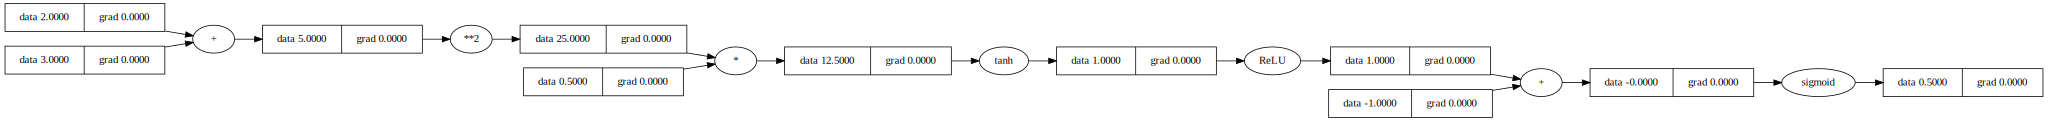

In [34]:
draw_dot(i)

In [35]:
c.grad

0

In [36]:
a.grad

0

In [37]:
i.backward()

0
Value(scalar=0.25)
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed


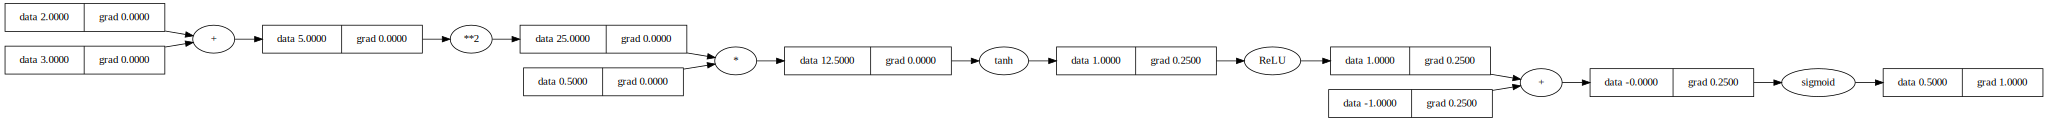

In [38]:
draw_dot(i)